ENV: spatial_ced_1

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(0)
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from datetime import datetime
from scipy.sparse import csc_matrix
from scipy.io import savemat
import dill
import json
import gseapy
import matplotlib as mpl
import math
import scipy
import plotly.express as px
from adjustText import adjust_text
from statsmodels.stats.multitest import multipletests
from scipy.stats import ranksums
from scipy.stats import wilcoxon
from scipy.stats import ttest_ind

from skimage.morphology import skeletonize
from skimage.graph import MCP
from skimage.measure import label
from scipy.ndimage import convolve

# from rasterio import features
from skimage.transform import resize
from skimage.measure import label, regionprops
# import rasterio
from shapely.geometry import LineString
from scipy.ndimage import gaussian_filter1d

from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")

import gseapy as gp
import sys
shedding_paper_utils = "/mnt/x/Common/Lab_Papers/shedding_potential/utils"
sys.path.append(shedding_paper_utils)
import plot_gsea
import importlib
# import py_funcs
import session_info2


mpl.rcParams['pdf.fonttype'] = 42 # to edit text in Illustrator
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams.update({
    "font.size": 14,    
    "axes.titlesize": 16,    
    "axes.labelsize": 14,  
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,  
    "legend.fontsize": 14
})
LOAD_ARIAL = True
if LOAD_ARIAL:
    # set the default font to Arial
    from matplotlib.font_manager import FontProperties, fontManager
    from matplotlib import rcParams
    # Path to Arial font
    arial_path = '/mnt/x/common/joint_projects/spatial_celiac/utils/Arial.ttf'

    # Define font properties with the specific path
    arial_font = FontProperties(fname=arial_path)
    fontManager.addfont(arial_path)

    # Set the font as the default for all text elements
    rcParams['font.family'] = arial_font.get_family()
    rcParams['font.sans-serif'] = [arial_font.get_name()]

In [2]:
fast_load = True
if fast_load:
    fast_load_prefix = "/mnt/d/celiac_files/"
else:   
    fast_load_prefix = ""

In [3]:
# joint_ad_path = fast_load_prefix+'all_ad_w_annotations_UMI100_leiden1.5.dill'#'joint_ad.dill'

# with open(joint_ad_path, 'rb') as f:
#     all_ad = dill.load(f)

In [4]:
all_px_path = fast_load_prefix+'joint_ad.dill'
with open(all_px_path, 'rb') as f:
    all_px = dill.load(f)

In [5]:
all_px.obs['sample_name'].unique()

array(['ST_033', 'ST_038', 'ST_052', 'ST_046', nan, 'ST_073', 'ST_054',
       'ST_004', 'ST_072', 'ST_060', 'ST_076', 'ST_105', 'ST_102',
       'ST_080B1', 'ST_109B1', 'ST_080B2', 'ST_109B2'], dtype=object)

In [6]:
samples_to_keep = ["ST_033","ST_038","ST_052","ST_046","ST_054","ST_004","ST_072",
"ST_076","ST_105","ST_102","ST_109B1","ST_080B1"]
print(all_px.shape)
all_px = all_px[all_px.obs['sample_name'].isin(samples_to_keep), :]
print(all_px.shape)

(718521, 18085)
(517198, 18085)


In [7]:
print(all_px.shape)
# remove pixel_class == "NA"
all_px = all_px[all_px.obs["pixel_class"].isin(['epithelium','non_epithelium']), :]


# remove pixels that are not in crypt
all_px = all_px[all_px.obs['MM_LP_crypt'],:]

# keep only epithelium pixels
all_px = all_px[all_px.obs['pixel_class'] == 'epithelium',:]
print(all_px.shape)

(517198, 18085)
(72223, 18085)


In [8]:
# # remove pixel_class == "NA"
# all_ad = all_ad[all_ad.obs["pixel_class"] != "NA", :]

# # remove pixels that are not in crypt
# all_ad = all_ad[all_ad.obs['MM_LP_crypt'],:]

# all_ad

In [9]:
# ent_ad = all_ad[all_ad.obs['cell_type_lvl1'] == 'Enterocytes', :].copy()
# ent_ad

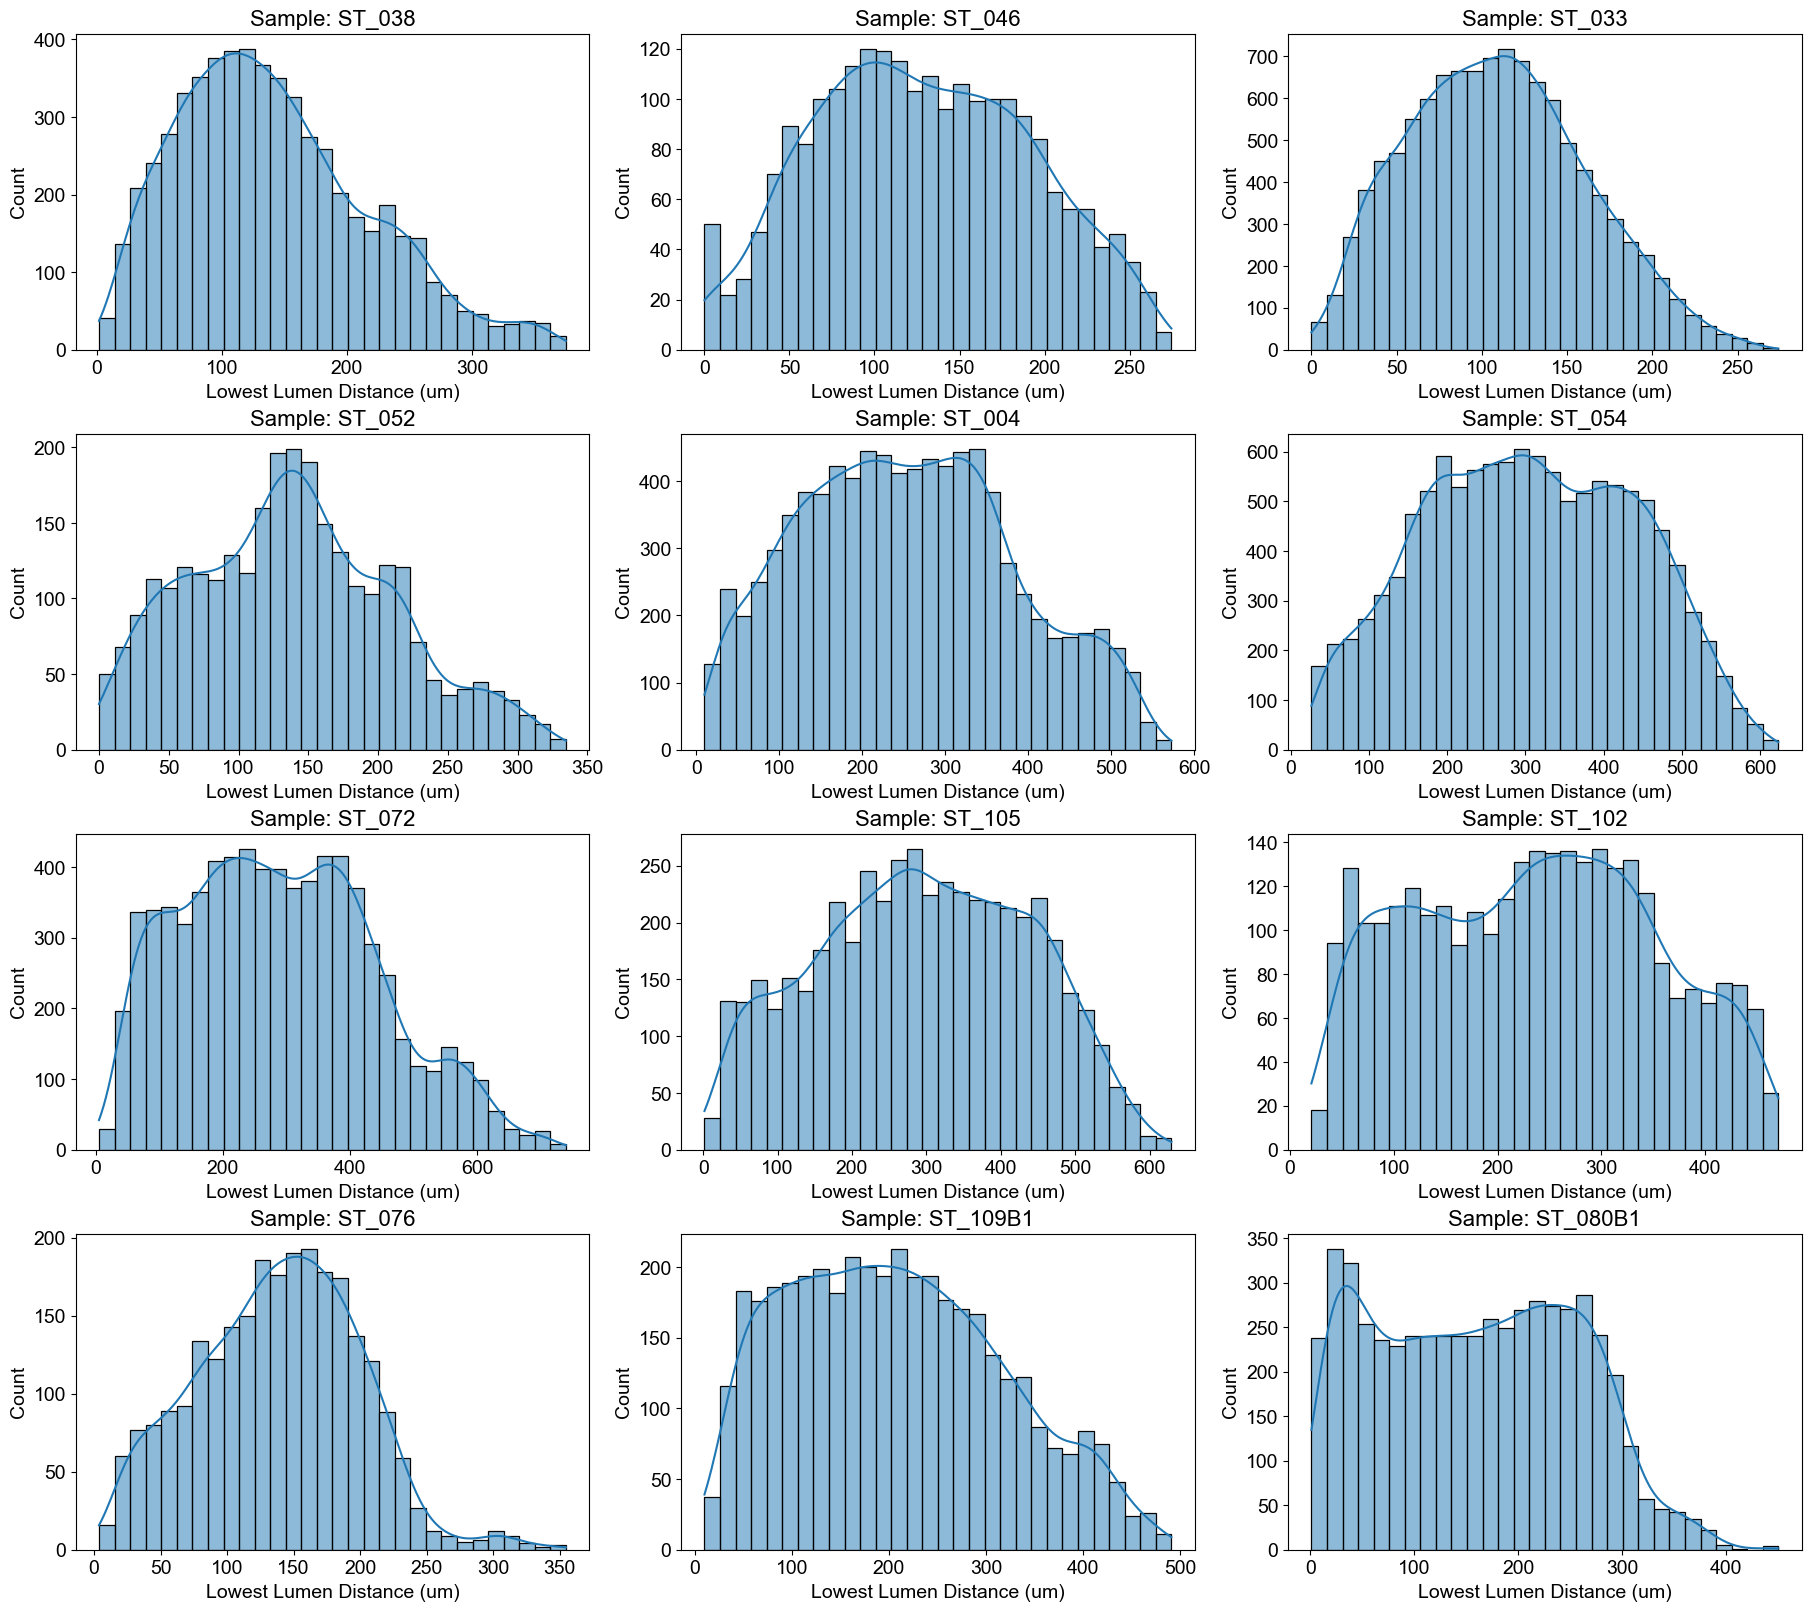

In [10]:
my_ad = all_px

# Get unique sample names
unique_samples = my_ad.obs['sample_name'].unique()

# Create subplots
n_samples = len(unique_samples)
n_cols = 3  # Number of columns for subplots
n_rows = math.ceil(n_samples / n_cols)  # Calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot histograms for each sample
for i, sample in enumerate(unique_samples):
    ax = axes[i]
    sns.histplot(my_ad[my_ad.obs['sample_name'] == sample, :].obs['lowest_lumen'], bins=30, kde=True, ax=ax)
    ax.set_title(f'Sample: {sample}')
    ax.set_xlabel('Lowest Lumen Distance (um)')
    ax.set_ylabel('Count')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [11]:
MIN_DIST = 50
MAX_DIST = 150
range_ent_ad = my_ad[(my_ad.obs['lowest_lumen'] >= MIN_DIST) & (my_ad.obs['lowest_lumen'] <= MAX_DIST), :]

# create pseudobulk per patient
pb_df = pd.DataFrame(columns=range_ent_ad.obs['sample_name'].unique(), index=range_ent_ad.var_names)
for my_sample in range_ent_ad.obs['sample_name'].unique():
    sample_ad = range_ent_ad[range_ent_ad.obs['sample_name'] == my_sample, :]
    # sum counts per gene
    gene_sums = np.array(sample_ad.layers['counts'].sum(axis=0)).flatten()
    genes_mat_norm = gene_sums / gene_sums.sum() 

    pb_df[my_sample] = genes_mat_norm

pb_df

,ST_038,ST_046,ST_033,ST_052,ST_054,ST_004,ST_072,ST_076,ST_102,ST_105,ST_109B1,ST_080B1
SAMD11,0.000016,0.000039,0.000005,0.000005,0.000019,0.000015,0.000014,0.000027,0.000000,0.000000,0.000000,0.000000
NOC2L,0.000060,0.000097,0.000067,0.000079,0.000015,0.000059,0.000067,0.000027,0.000000,0.000000,0.000021,0.000035
KLHL17,0.000008,0.000016,0.000012,0.000015,0.000026,0.000015,0.000014,0.000000,0.000000,0.000000,0.000042,0.000000
PLEKHN1,0.000000,0.000000,0.000000,0.000000,0.000008,0.000007,0.000037,0.000027,0.000000,0.000000,0.000063,0.000000
PERM1,0.000000,0.000004,0.000000,0.000010,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,0.002065,0.002707,0.008103,0.003008,0.001537,0.002042,0.001215,0.005607,0.007089,0.001586,0.004550,0.004735
MT-ND4,0.002244,0.001731,0.005660,0.002785,0.001544,0.001735,0.000998,0.007221,0.009707,0.002318,0.004487,0.005978
MT-ND5,0.001237,0.001186,0.001961,0.001758,0.000823,0.000599,0.000415,0.006291,0.021922,0.003386,0.007108,0.004173
MT-ND6,0.001842,0.002392,0.005980,0.002706,0.001244,0.000888,0.001415,0.010476,0.020068,0.004576,0.008367,0.004653


In [12]:
# identify ced patients and controls
ced_patients = range_ent_ad[range_ent_ad.obs.group=='celiac'].obs.sample_name.unique()
control_patients = range_ent_ad[range_ent_ad.obs.group=='control'].obs.sample_name.unique()

# mean control & celiac
PN=1e-6
mn_control = pb_df.loc[:,control_patients].mean(axis=1)
mn_ced = pb_df.loc[:,ced_patients].mean(axis=1)
log2fc = np.log2((mn_ced + PN)/(mn_control + PN))
mx = np.max([mn_control, mn_ced],axis=0)

# create dataframe
ma_df = pd.DataFrame({
    'gene_name': mn_control.index,
    'mean_control': mn_control.values,
    'mean_celiac': mn_ced.values,
    'log2FC': np.log2(log2fc),
    'max': mx,
    'log10_max':np.log10(mx+PN)
})
ma_df

,gene_name,mean_control,mean_celiac,log2FC,max,log10_max
SAMD11,SAMD11,0.000016,9.398370e-06,NaN,0.000016,-4.767654
NOC2L,NOC2L,0.000076,2.811100e-05,NaN,0.000076,-4.115411
KLHL17,KLHL17,0.000013,1.216078e-05,NaN,0.000013,-4.865969
PLEKHN1,PLEKHN1,0.000000,1.772691e-05,2.079648,0.000018,-4.727534
PERM1,PERM1,0.000003,4.624799e-07,NaN,0.000003,-5.352455
...,...,...,...,...,...,...
MT-ND4L,MT-ND4L,0.003971,3.545279e-03,NaN,0.003971,-2.401024
MT-ND4,MT-ND4,0.003105,4.248466e-03,-1.145116,0.004248,-2.371666
MT-ND5,MT-ND5,0.001536,5.589639e-03,0.897832,0.005590,-2.252539
MT-ND6,MT-ND6,0.003230,6.460647e-03,-0.000252,0.006461,-2.189657


In [13]:
# import crypt and TA markers
flex_sigs = pd.read_csv("flex_signature_table_cell_type_lvl2_bg_substracted.csv", index_col=0)
# find markers
FC_THRESH = 2
EXP_THRESH = 1e-5
markers_dict = {}
for my_cell_type in flex_sigs.columns:
    my_cell_exp = flex_sigs.loc[:,my_cell_type]
    other_cell_types = np.setdiff1d(flex_sigs.columns, my_cell_type).tolist()
    max_other_cells_exp = flex_sigs.loc[:,other_cell_types].max(axis=1)

    cell_markers_mask = (my_cell_exp > EXP_THRESH) & (my_cell_exp > max_other_cells_exp * FC_THRESH)
    markers_dict[my_cell_type] = flex_sigs.index[cell_markers_mask]
flex_sigs

,Enterocytes,TA,Paneth,NKT,Goblet,Brunner,B_cells,EEC,Proliferation,MUC5AC_metaplasia,...,DC,DUOX2_Enterocytes,Lymphatics_cells,Endothelial_cells,Fibroblasts,Mast,Plasma,Tip_telocytes,Glia,Crypt_telocytes
SAMD11,2.457784e-06,2.373687e-06,0.000009,0.000003,1.043966e-05,2.518631e-05,0.000021,0.000669,0.000009,0.000015,...,5.185141e-07,0.000007,0.000007,0.000032,0.000635,0.000015,0.000004,0.000397,0.000141,0.000343
NOC2L,4.191400e-05,7.472853e-05,0.000052,0.000074,4.426179e-05,5.115170e-05,0.000040,0.000047,0.000057,0.000071,...,3.547834e-05,0.000018,0.000079,0.000032,0.000071,0.000049,0.000063,0.000066,0.000029,0.000095
KLHL17,3.147357e-05,3.985392e-05,0.000036,0.000065,3.437759e-05,6.117953e-05,0.000052,0.000047,0.000102,0.000060,...,8.344126e-05,0.000028,0.000052,0.000035,0.000095,0.000011,0.000090,0.000119,0.000070,0.000023
PLEKHN1,1.220998e-05,6.015000e-06,0.000017,0.000070,1.611063e-05,2.982228e-05,0.000037,0.000021,0.000020,0.000205,...,4.406137e-05,0.000269,0.000000,0.000002,0.000025,0.000006,0.000132,0.000058,0.000000,0.000006
PERM1,8.274028e-08,4.389383e-08,0.000000,0.000000,3.591062e-08,3.044572e-07,0.000000,0.000002,0.000002,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,3.538220e-04,4.042105e-04,0.000324,0.000086,4.827249e-04,2.711212e-04,0.000058,0.000241,0.000182,0.000243,...,6.732188e-05,0.000156,0.000073,0.000141,0.000066,0.000175,0.000057,0.000029,0.000082,0.000111
MT-ND4,4.531661e-04,4.850389e-04,0.000408,0.000110,5.717918e-04,3.986069e-04,0.000100,0.000288,0.000227,0.000308,...,1.122610e-04,0.000285,0.000134,0.000102,0.000080,0.000218,0.000085,0.000105,0.000060,0.000143
MT-ND5,2.053260e-04,1.985270e-04,0.000169,0.000065,2.934978e-04,1.430159e-04,0.000032,0.000135,0.000130,0.000100,...,3.752861e-05,0.000077,0.000115,0.000057,0.000068,0.000078,0.000047,0.000042,0.000000,0.000036
MT-ND6,3.263017e-03,5.941043e-03,0.008728,0.000949,8.328333e-03,2.654274e-03,0.001877,0.003221,0.002646,0.002670,...,2.455357e-03,0.001696,0.000667,0.001247,0.000773,0.000959,0.001897,0.000198,0.000336,0.000146


In [14]:
# select cells to create dataframe
selected_cell_types = []#["TA","Stem","Paneth"]
# Filter markers for the selected cell types
selected_markers = {cell_type: markers_dict[cell_type] for cell_type in selected_cell_types}

# Create a DataFrame with the markers
selected_markers_df = pd.DataFrame(
    [(cell_type, gene) for cell_type, genes in selected_markers.items() for gene in genes],
    columns=['cell_type', 'gene']
)

selected_markers_df

,cell_type,gene


In [15]:
epi_markers = pd.read_csv("enterocyte_zonation_markers.csv", index_col=False)
# Reshape the DataFrame to a tidy format
epi_markers = epi_markers.melt(var_name='zone', value_name='gene')

# add additional selected_markers_df
markers_df = pd.concat([epi_markers, selected_markers_df.rename(columns={'cell_type': 'zone'})], ignore_index=True)

# add exp in celiac and in control
markers_df['log10_exp_control'] = np.log10(markers_df['gene'].map(mn_control)+PN)
markers_df['log10_exp_ced'] = np.log10(markers_df['gene'].map(mn_ced)+PN)
# # add log2fc accoring to gene
markers_df['log2FC'] = epi_markers['gene'].map(log2fc)
markers_df['log10_max'] = np.max([markers_df['log10_exp_control'],markers_df['log10_exp_ced']],axis=0)

unmelted_markers_df = markers_df.copy()

# turn markers_df into tidy data
# Reshape markers_df to tidy format with 'condition' and 'expression' fields
markers_df = markers_df.melt(
    id_vars=['zone', 'gene'],
    value_vars=['log10_exp_control', 'log10_exp_ced'],
    var_name='condition',
    value_name='expression'
)

# Map condition names to 'control' and 'ced'
markers_df['condition'] = markers_df['condition'].map({
    'log10_exp_control': 'control',
    'log10_exp_ced': 'ced'
})

markers_df


,zone,gene,condition,expression
0,bottom_markers,EXOC3L4,control,-3.706938
1,bottom_markers,AKAP7,control,-3.701706
2,bottom_markers,EPS8L3,control,-2.897962
3,bottom_markers,KHK,control,-3.344353
4,bottom_markers,AADAC,control,-3.581795
...,...,...,...,...
235,tip_markers,APOA1,ced,-3.701556
236,tip_markers,APOA4,ced,-3.364227
237,tip_markers,SLC46A1,ced,-3.973064
238,tip_markers,PTPRR,ced,-4.589779


In [16]:
sig_dict = dict()
for my_zone in unmelted_markers_df['zone'].unique():
    # Filter rows for the current zone
    my_group = unmelted_markers_df.loc[unmelted_markers_df['zone'] == my_zone]
    # Perform Wilcoxon signed-rank test between exp_control and exp_ced
    stat, pval = wilcoxon(my_group['log10_exp_control'], my_group['log10_exp_ced'])
    # Use the zone name as the dictionary key
    sig_dict[my_zone] = pval
    print(f"{my_zone}: wilcoxon signed-rank test statistic: {stat}, p-value: {pval}")


bottom_markers: wilcoxon signed-rank test statistic: 382.0, p-value: 0.7145974449867936
mid_markers: wilcoxon signed-rank test statistic: nan, p-value: nan
tip_markers: wilcoxon signed-rank test statistic: 189.0, p-value: 0.002392230499026482


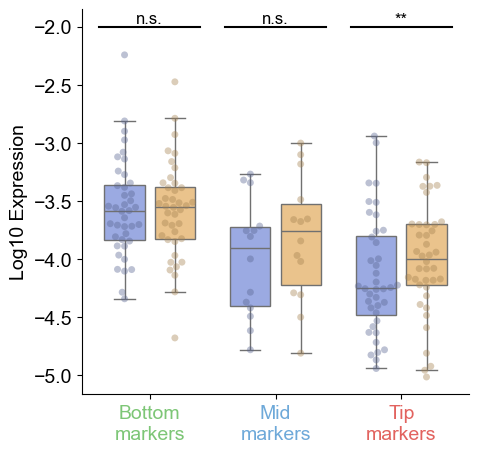

In [17]:
# col_order = ['Paneth','Stem','TA','bottom_markers','mid_markers','tip_markers']
col_order = ['bottom_markers','mid_markers','tip_markers']
boxplot_palette = {"ced":"#fac67c","control":"#8fa3ee"}
swarm_palette = {"ced":"#a68351","control":"#596591"}
fig,ax = plt.subplots(figsize=(5,5))
# sns.boxplot(data=markers_df, x='zone', y='expression', hue='condition', palette=boxplot_palette, order=col_order, showfliers=False, ax=ax, gap=0.2)
sns.boxplot(
    data=markers_df, 
    x='zone', 
    y='expression', 
    hue='condition', 
    palette=boxplot_palette, 
    order=col_order, 
    showfliers=False, 
    ax=ax, 
    gap=0.2, 
    # boxprops=dict(color='black'),  # Set box outline color to black
    # whiskerprops=dict(color='black')  # Set whisker color to black
)
sns.swarmplot(data=markers_df, x='zone', y='expression', hue='condition', palette=swarm_palette, order=col_order, dodge=True, size=5, alpha=0.4,ax=ax,)

# add lines between each pair of boxplot
y_pos = -2
astricks_dict = {0.001: '***', 0.01: '**', 0.05: '*'}
delta = 0.1
for ii,ct in enumerate(col_order):
    plt.plot([ii-0.5+delta, ii +0.5-delta],[y_pos, y_pos], c='k')
    flag = False
    for p_thresh in sorted(astricks_dict.keys(), reverse=False):
        if sig_dict[ct] < p_thresh:
            plt.text(ii, y_pos, astricks_dict[p_thresh], ha='center', va='bottom', color='k', fontsize=12)
            flag = True
            break
    if not flag:
        plt.text(ii, y_pos, "n.s.", ha='center', va='bottom', color='k', fontsize=12)

# hide legend
sns.despine()
plt.ylabel("Log10 Expression")
plt.xlabel("")
plt.legend([], [], frameon=False)
# plt.xticks(rotation=45, ha='right')
# color bottom_markers in green
# Highlight 'bottom_markers' in green
# Use the dictionary to set colors for tick labels
text_colors_dict = {"bottom_markers":"#7dc676","mid_markers":"#6ea9d9","tip_markers":"#e2635f"}
for tick_label in plt.gca().get_xticklabels():
    label_text = tick_label.get_text()
    if label_text in text_colors_dict:
        tick_label.set_color(text_colors_dict[label_text])

plt.gca().set_xticklabels([label.replace('_', '\n').capitalize() if label != 'TA' else 'TA' for label in col_order])
# Save the figure to a file
output_path = os.getcwd()+"/figures/supp_tip_base_correlation/boxplot_expression_zones.pdf"
fig.savefig(output_path, format='pdf', bbox_inches='tight')
plt.show()

# export to supplemnary A markers tip/base + correlations

In [18]:
print(session_info2.session_info(dependencies=True))

pandas	2.3.2
scanpy	1.11.4
numpy	2.2.6
tqdm	4.67.1
seaborn	0.13.2
matplotlib	3.10.6
geopandas	1.1.1
scipy	1.15.3
dill	0.4.0
gseapy	1.1.10
plotly	6.3.0
adjustText	1.3.0
statsmodels	0.14.5
scikit-image	0.25.2
shapely	2.1.1
anndata	0.12.2
----	----
Pygments	2.19.2
asttokens	3.0.0
narwhals	2.5.0
Jinja2	3.1.6
MarkupSafe	3.0.2
Deprecated	1.2.18
pyzmq	27.1.0
urllib3	2.5.0
pillow	11.3.0
numcodecs	0.15.1
numba	0.61.2
threadpoolctl	3.6.0
six	1.17.0
pyproj	3.7.2
idna	3.10
sphinxcontrib-devhelp	2.0.0
patsy	1.0.1
llvmlite	0.44.0
debugpy	1.8.16
igraph	0.11.9
lazy_loader	0.4
wrapt	1.17.3
leidenalg	0.10.2
joblib	1.5.2
ipykernel	6.30.1
sphinxcontrib-qthelp	2.0.0
jupyter_client	8.6.3
jedi	0.19.2
typing_extensions	4.15.0
pyarrow	21.0.0
traitlets	5.14.3
packaging	25.0
toolz	1.0.0
texttable	1.7.0
pytz	2025.2
sphinxcontrib-htmlhelp	2.1.0
parso	0.8.5
charset-normalizer	3.4.3
ipython	9.5.0
natsort	8.4.0
legacy-api-wrap	1.4.1
crc32c	2.7.1
matplotlib-inline	0.1.7
platformdirs	4.4.0
decorator	5.2.1
session-info2